In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def _ols_with_uncertainty(x, y):
    """
    Ordinary least squares for y = m*x + c.
    Returns:
        m, c      : slope and intercept
        sm, sc    : 1σ uncertainties on m and c
        R2        : coefficient of determination
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x)

    # Design matrix [x, 1]
    X = np.vstack([x, np.ones_like(x)]).T

    # OLS solution
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    m, c = float(beta[0]), float(beta[1])

    # Residuals and variance estimate
    y_hat = m * x + c
    resid = y - y_hat
    dof = max(n - 2, 1)
    s2 = np.sum(resid**2) / dof  # residual variance

    # Parameter uncertainties
    Sxx = np.sum((x - x.mean())**2)
    sm = np.sqrt(s2 / Sxx) if Sxx > 0 else np.nan
    sc = np.sqrt(s2 * (1/n + x.mean()**2 / Sxx)) if Sxx > 0 else np.nan

    # R^2
    ss_res = np.sum(resid**2)
    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return m, c, sm, sc, float(R2)


def york_fit(x, y, sx, sy=None, max_iter=50, tol=1e-12):
    """
    York (2004) linear regression for y = m*x + c with errors in x and/or y.
    Inputs:
        x, y : data arrays
        sx   : 1σ uncertainties in x
        sy   : 1σ uncertainties in y (optional; if None, uses zeros)
    Returns:
        m, c      : slope and intercept
        sm, sc    : 1σ uncertainties on m and c
        R2        : R-squared using the fitted line
    Falls back to OLS if all uncertainties are zero.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    sx = np.asarray(sx, float)
    sy = np.zeros_like(x, dtype=float) if sy is None else np.asarray(sy, float)

    # No uncertainties → use OLS
    if not np.any(sx > 0) and not np.any(sy > 0):
        return _ols_with_uncertainty(x, y)

    # Initial slope from OLS
    m, c, _, _, _ = _ols_with_uncertainty(x, y)

    # Iterate to refine slope
    for _ in range(max_iter):
        wi = 1.0 / (m*m * sx*sx + sy*sy)
        xbar = np.sum(wi * x) / np.sum(wi)
        ybar = np.sum(wi * y) / np.sum(wi)
        Ui = x - xbar
        Vi = y - ybar
        beta = wi * (Ui / (sx*sx))
        denom = np.sum(wi * beta * Ui)
        if denom == 0:
            break
        m_new = np.sum(wi * beta * Vi) / denom
        if abs(m_new - m) < tol * (1 + abs(m)):
            m = m_new
            break
        m = m_new

    c = ybar - m * xbar

    # Uncertainty estimates (York)
    wi = 1.0 / (m*m * sx*sx + sy*sy)
    xbar = np.sum(wi * x) / np.sum(wi)
    Ui = x - xbar
    WU2 = np.sum(wi * Ui*Ui)
    sm = np.sqrt(1.0 / WU2) if WU2 > 0 else np.nan
    sc = np.sqrt(1.0/np.sum(wi) + xbar*xbar * sm*sm) if np.sum(wi) > 0 else np.nan

    # R^2 on the fitted line
    y_hat = m * x + c
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    return float(m), float(c), float(sm), float(sc), float(R2)


In [3]:
# Each row is: (label, channel_centroid, centroid_uncertainty, energy_keV)
DETECTORS = {
    "BGO": [
        ("241Am", 145.43, 0.05, 59.54),
        ("137Cs", 1724.39, 0.12, 661.70),
        ("60Co",  3061.74, 1.88, 1173.20),
        ("60Co",  3483.43, 1.81, 1332.50),
    ],
    "NaI": [
        ("241Am", 22.94, 0.02, 59.54),
        ("22Na",  164.34, 0.46, 511.00),
        ("137Cs", 207.63, 0.03, 661.70),
        ("60Co",  354.87, 0.82, 1173.20),
        ("60Co",  403.24, 1.00, 1332.50),
    ],
    "CSI": [
        ("137Cs", 1656.43, 0.31, 661.657),
        ("60Co",   605.01, 3.16, 209.8),     # kept as provided
        ("22Na",  1324.64, 0.31, 511.000),
    ],
    "LYSO": [
        ("137Cs", 1173.90, 0.10, 661.657),
        ("60Co",   450.87, 1.61, 209.8),     # kept as provided
        ("22Na",   787.57, 0.08, 511.000),
        ("22Na",  1967.86, 0.35, 1274.537),
    ],
    "Plastic": [
        ("137Cs",            2140.87, 1.66, 661.657),
        ("22Na",             1513.44, 1.78, 1274.537),
        ("22Na(backscatter)", 199.34, 0.77, 341.0),
    ],
}

print("Loaded detectors:", ", ".join(sorted(DETECTORS)))


Loaded detectors: BGO, CSI, LYSO, NaI, Plastic


In [4]:
# Choose which detector to analyze
SELECTED_DETECTOR = "LYSO"  # options: "BGO", "NaI", "CSI", "LYSO", "Plastic"

def normalize_rows(rows):
    """
    Convert detector rows to arrays.
    Input row format: (label, centroid, centroid_err, energy_keV)
    Returns:
        labels (str array), ch (float), ch_err (float), E_keV (float)
    """
    labels, ch, ch_err, E = [], [], [], []
    for r in rows:
        if len(r) != 4:
            raise ValueError(f"Row {r} has unsupported length {len(r)}; expected 4.")
        s, centroid, centroid_err, energy = r
        labels.append(str(s))
        ch.append(float(centroid))
        ch_err.append(np.nan if centroid_err is None else float(centroid_err))
        E.append(float(energy))
    return np.array(labels), np.array(ch, float), np.array(ch_err, float), np.array(E, float)

# Fetch and normalize the selected dataset
rows = DETECTORS.get(SELECTED_DETECTOR)
if rows is None or len(rows) == 0:
    raise ValueError(f"No data rows found for detector: {SELECTED_DETECTOR}")

labels, ch, ch_err, E_keV = normalize_rows(rows)

# For plotting, replace NaN x-errors with 0 (so only known errors are drawn)
xerr_plot = np.where(np.isfinite(ch_err), ch_err, 0.0)
show_xerr = np.any(xerr_plot > 0)


Energy calibration (linear):  E = m·channel + c
 m = 0.417336 ± 0.000100 keV/channel
 c = 186.445 ± 0.100 keV
 R² = 0.83635
 Fit method: York (errors-in-variables)



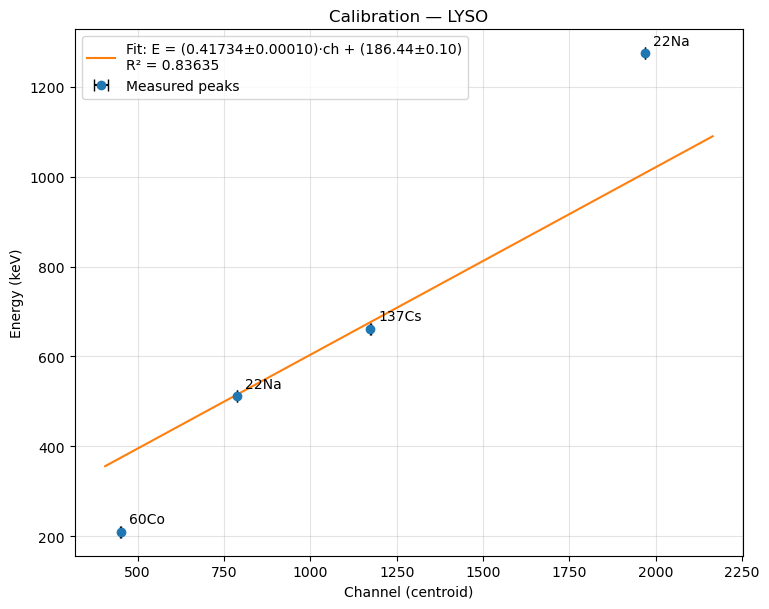

In [5]:
# Choose fitting method:
# "auto" = York if any x-error > 0, else OLS
# "york" = force York (errors-in-variables)
# "ols"  = force ordinary least squares
FIT_METHOD = "auto"

if FIT_METHOD == "ols":
    m, c, sm, sc, R2 = _ols_with_uncertainty(ch, E_keV)
    method_used = "OLS"
elif FIT_METHOD == "york":
    m, c, sm, sc, R2 = york_fit(ch, E_keV, sx=xerr_plot, sy=None)
    method_used = "York (errors-in-variables)"
else:  # auto
    if show_xerr:
        m, c, sm, sc, R2 = york_fit(ch, E_keV, sx=xerr_plot, sy=None)
        method_used = "York (errors-in-variables)"
    else:
        m, c, sm, sc, R2 = _ols_with_uncertainty(ch, E_keV)
        method_used = "OLS"

print("Energy calibration (linear):  E = m·channel + c")
print(f" m = {m:.6f} ± {sm:.6f} keV/channel")
print(f" c = {c:.3f} ± {sc:.3f} keV")
print(f" R² = {R2:.5f}")
print(f" Fit method: {method_used}\n")

# Line for plotting
x_line = np.linspace(ch.min() * 0.9, ch.max() * 1.1, 400)
y_line = m * x_line + c

# Plot data with optional horizontal error bars and the fitted line
plt.figure(figsize=(7.8, 6.2))
plt.errorbar(
    ch, E_keV,
    xerr=(xerr_plot if show_xerr else None),
    yerr=None,
    fmt="o", capsize=4, elinewidth=1.5, ecolor="black",
    label="Measured peaks"
)
plt.plot(
    x_line, y_line,
    label=f"Fit: E = ({m:.5f}±{sm:.5f})·ch + ({c:.2f}±{sc:.2f})\nR² = {R2:.5f}"
)

# Annotate each point with its label
for xi, yi, s in zip(ch, E_keV, labels):
    plt.annotate(s, (xi, yi), textcoords="offset points", xytext=(6, 6), fontsize=10)

plt.xlabel("Channel (centroid)")
plt.ylabel("Energy (keV)")
plt.title(f"Calibration — {SELECTED_DETECTOR}")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


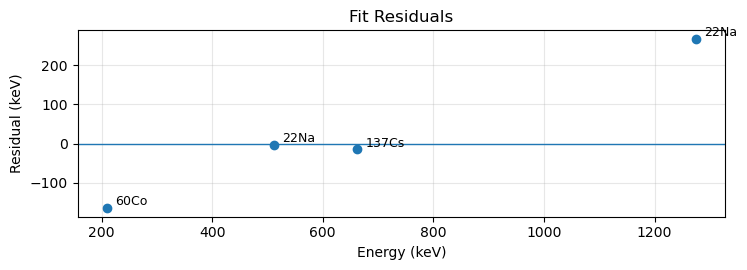

In [6]:
# Residuals (how far points are from the fitted line)
res = E_keV - (m * ch + c)

plt.figure(figsize=(7.6, 2.8))
plt.axhline(0.0, linewidth=1)
plt.scatter(E_keV, res)

# Label residual points
for Ei, ri, s in zip(E_keV, res, labels):
    plt.annotate(s, (Ei, ri), textcoords="offset points", xytext=(6, 2), fontsize=9)

plt.xlabel("Energy (keV)")
plt.ylabel("Residual (keV)")
plt.title("Fit Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
